In [ ]:
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 267.1 MB 9.7 kB/s 
     |████████████████████████████████| 281 kB 4.3 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import torch
import nltk

from collections import defaultdict
from sklearn.decomposition import PCA
import joblib
from dgl.data.utils import save_graphs, load_graphs

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
data_postEmb=np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_2sent(1).npy', allow_pickle=True)
#pca=joblib.load('/content/drive/MyDrive/BlogAuthorClass/PCA_Mono384_2sent.pkl')
#text=pd.read_csv("/content/drive/MyDrive/BlogAuthorClass/blogtext_2sent.csv")

In [ ]:
window_size=2
device = torch.device('cuda')
post_graph_list=[]

def convert_bool2int(inp):
    return node_bool2int[inp]

for postEmb in data_postEmb:
    node_dict=defaultdict(list)
    src_dict=defaultdict(list)
    dst_dict=defaultdict(list)
    sliding_window=[]
    node_attribute=[]
    
    post_sentwise_clu = pca.transform(postEmb)<0    # dividing latent space for clustering
    for sent_clu, sent_emb in zip(post_sentwise_clu, postEmb):
        sent_clu=tuple(sent_clu)
        node_dict[sent_clu].append(sent_emb)        # node features

        temp_ws=len(sliding_window)
        for i in range(temp_ws):
            src_dict[str(i+1)+"hop"].append(sliding_window[temp_ws-1-i])
            dst_dict[str(i+1)+"hop"].append(sent_clu)
            
            
        sliding_window.append(sent_clu)
        if len(sliding_window) > window_size:
            sliding_window.pop(0)

            
    sent_nodes = node_dict.keys()
    node_bool2int = defaultdict()
    for nodeBool,nodeInt in zip(sent_nodes, range(len(sent_nodes))):
        node_bool2int[nodeBool]=nodeInt
        node_attribute.append(sum(node_dict[nodeBool])/len(node_dict[nodeBool]))
        
    
    for i in range(window_size):
        src_dict[str(i+1)+"hop"]=torch.tensor(list(map(convert_bool2int,src_dict[str(i+1)+"hop"])))
        dst_dict[str(i+1)+"hop"]=torch.tensor(list(map(convert_bool2int,dst_dict[str(i+1)+"hop"])))
    
    g=defaultdict()
    for i in range(window_size):
        g[("f", str(i+1)+"hop", "f")] = (src_dict[str(i+1)+"hop"],dst_dict[str(i+1)+"hop"])
    
    try :
        g=dgl.heterograph(g).to_simple(return_counts="overlap").to(device)
        g.ndata['f'] = torch.tensor(node_attribute, device='cuda')
    except :   # for cases which has fewer or same node numbers then "window_size"
        g.popitem()
        g=dgl.heterograph(g).to_simple(return_counts="overlap").to(device)
        g.ndata['f'] = torch.tensor(node_attribute, device='cuda')
    print(node_attribute)
    post_graph_list.append(g)
    print(post_graph_list[-1].ndata['f'])

In [ ]:
save_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list_2sent(1).bin", post_graph_list)

In [ ]:
post_graph_list = load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(total).bin")[0]

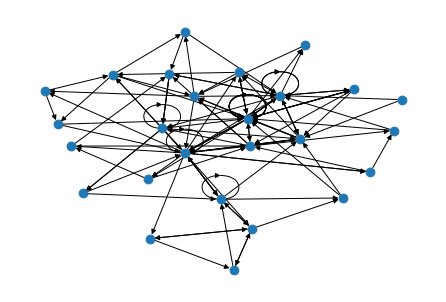

In [ ]:
nx.draw_kamada_kawai(dgl.to_homogeneous(post_graph_list[43310]).cpu().to_networkx(), node_size=77)

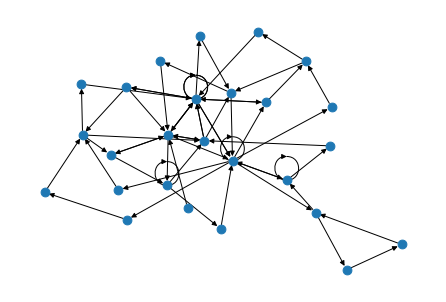

In [ ]:
nx.draw_kamada_kawai(post_graph_list[43310][('f','1hop','f')].cpu().to_networkx(), node_size=77)

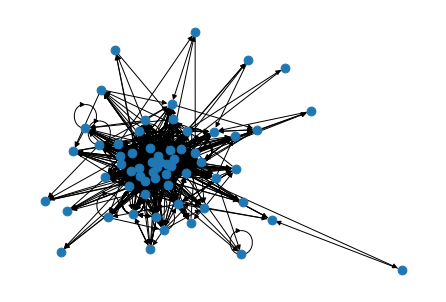

In [ ]:
nx.draw(post_graph_list[455081][('f','1hop','f')].cpu().to_networkx(), node_size=77)

In [ ]:
post_graph_list = load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(1).bin")[0]+load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(2).bin")[0]+load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(3).bin")[0]+load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(4).bin")[0]+load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(5).bin")[0]+load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(6).bin")[0]

In [ ]:
save_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(total).bin", post_graph_list)

In [ ]:
post_graph_list = load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(total).bin")[0]

In [ ]:
post_graph_list[43310]

Graph(num_nodes={'f': 26},
      num_edges={('f', '1hop', 'f'): 60, ('f', '2hop', 'f'): 59},
      metagraph=[('f', 'f', '1hop'), ('f', 'f', '2hop')])

In [ ]:
sum([np.array([1,2,3,4,5]),np.array([2,3,4,5,6])])

array([ 3,  5,  7,  9, 11])

In [ ]:
post_graph_list[43310].ndata

{'f': tensor([[-0.0271,  0.0286,  0.0270,  ...,  0.0582, -0.0076,  0.0372],
        [-0.0152, -0.0541,  0.0423,  ..., -0.0067, -0.0212, -0.0032],
        [-0.0439,  0.0170,  0.0490,  ...,  0.0058, -0.0190, -0.0089],
        ...,
        [ 0.0885,  0.0244,  0.0594,  ..., -0.0675, -0.1185,  0.0330],
        [ 0.0405,  0.0055,  0.0482,  ...,  0.0577,  0.0202, -0.0071],
        [-0.0287, -0.0060,  0.1122,  ..., -0.0154,  0.0285, -0.0536]],
       device='cuda:0')}

In [ ]:
g.ndata["f"]=torch.tensor(node_attribute,device='cuda')

In [ ]:
numedge=[]
for i in post_graph_list :
    numedge.append(i.num_edges())

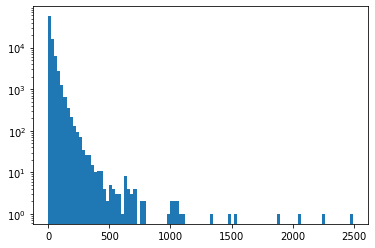

In [ ]:
nums2,inds2,_ = plt.hist(numedge,bins=100)
plt.yscale("log")

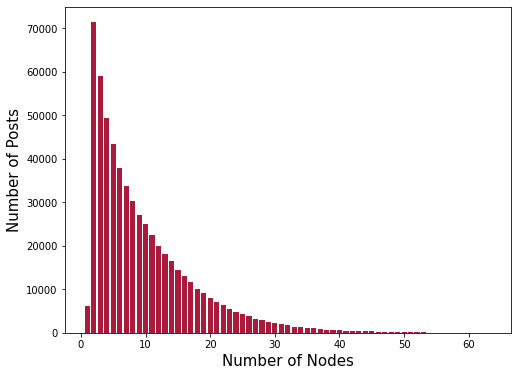

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(inds[:-1],nums, color='#AB1A3A')
#plt.title("Blog User Age Distribution", fontsize=17)
plt.xlabel("Number of Nodes", fontsize=15)
plt.ylabel("Number of Posts", fontsize=15)

plt.savefig("node_dist(post).pdf", dpi=300)

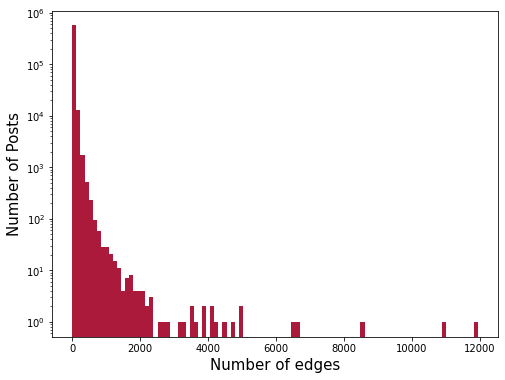

In [ ]:
plt.figure(figsize=(8,6))
#plt.bar(inds2[:-1],nums2, color='#AB1A3A')
plt.hist(numedge,bins=100, color='#AB1A3A')
#plt.title("Blog User Age Distribution", fontsize=17)
plt.xlabel("Number of edges", fontsize=15)
plt.ylabel("Number of Posts", fontsize=15)
#plt.xscale('log')
plt.yscale('log')

plt.savefig("edge_dist(post).pdf", dpi=300)

In [ ]:
np.sum(np.array(numnode)>3)/len(numnode)

0.7661393363129294

In [ ]:
np.sum(np.array(numnode)<15)/len(numnode)

0.7882588177742657

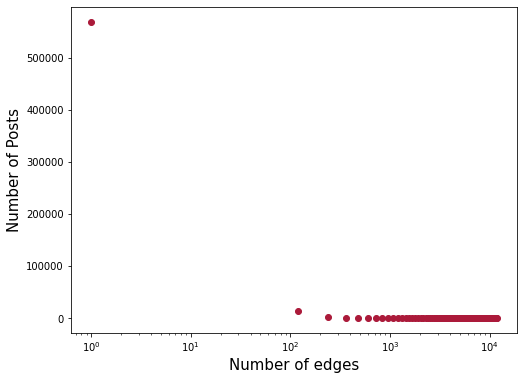

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(inds2[:-1],nums2, color='#AB1A3A')
#plt.title("Blog User Age Distribution", fontsize=17)
plt.xlabel("Number of edges", fontsize=15)
plt.ylabel("Number of Posts", fontsize=15)
plt.xscale('log')
#plt.yscale('log')

#plt.savefig("edge_dist(post).pdf", dpi=300)

In [ ]:
numedgenp=np.array(numedge)
np.where(numedgenp==11947)

(array([455081]),)

In [ ]:
post_graph_list[455081].num_edges()

11947

In [ ]:
max(np.delete(numedgenp,455081))

10959

In [ ]:
post_graph_list[888]

Graph(num_nodes={'f': 10},
      num_edges={('f', '1hop', 'f'): 12, ('f', '2hop', 'f'): 11},
      metagraph=[('f', 'f', '1hop'), ('f', 'f', '2hop')])

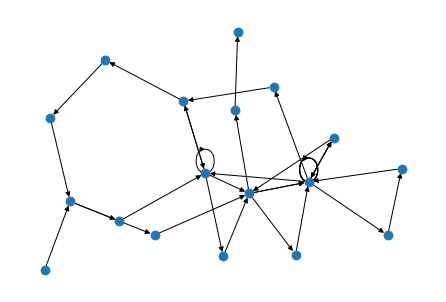

In [ ]:
nx.draw_kamada_kawai(post_graph_list[7388][('f','1hop','f')].cpu().to_networkx(), node_size=77)

In [ ]:
gr2 = post_graph_list[7388].cpu()[('f','1hop','f')]
gr2.edges()

(tensor([ 0,  1,  2,  3,  4,  4,  5,  4,  6,  6,  7,  6,  3,  4,  8,  7,  9, 10,
          1, 11,  6, 12,  3, 13,  4,  4,  4,  4, 14, 15,  4,  5,  3, 16]),
 tensor([ 1,  2,  3,  4,  4,  5,  4,  6,  6,  7,  6,  3,  4,  8,  7,  9, 10,  1,
         11,  6, 12,  3, 13,  4,  4,  4,  4, 14, 15,  4,  5,  3, 16, 17]))

In [ ]:
gr=post_graph_list[7388].cpu().to_simple(return_counts="cnt")[('f','1hop','f')]
gr.edges() # src,dst 반환

(tensor([ 0,  1,  1,  2,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  6,  6,  6,  6,
          7,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 tensor([ 1,  2, 11,  3,  4, 13, 16,  4,  5,  6,  8, 14,  3,  4,  3,  6,  7, 12,
          6,  9,  7, 10,  1,  6,  3,  4, 15,  4, 17]))